In [ ]:
import json
import random
import time
import math
from dataclasses import dataclass, field
from pathlib import Path
from typing import Dict

import numpy as np
import pandas as pd
from mesa import Agent, Model
from mesa.agent import AgentSet

try:
    import networkx as nx
    HAS_NX = True
except ImportError:
    HAS_NX = False

In [ ]:
@dataclass
class SIM_CONFIG:
    n_agents: int = 100
    n_seasons: int = 30
    random_seed: int = 42
    noise_std: float = 0.10
    suitability_noise_std: float = 0.08 # per-farmer
    use_neighbor_graph: bool = True
    network_topology: str = "small_world" # small_world | random | scale_free
    network_k: int = 4
    knowledge_filter_mode: str = "filter" # filter (zone-only) | weighted | none
    shared_strategy: str = "both" # zone | neighbor | both  (zone aggregate + neighbor propagation)
    use_profit: bool = True
    zone_weight: float = 0.30
    soil_weight: float = 0.25
    climate_weight: float = 0.25
    moisture_weight: float = 0.10
    shared_weight: float = 0.60
    neighbor_weight: float = 0.20
    experience_weight: float = 0.25
    min_neighbor_obs: int = 3   # Minimum observations before trusting neighbor data and sharing it
    variability_min: float = 0.85
    variability_max: float = 1.15
    water_need_mm: Dict[str, int] = field(default_factory=lambda: {"low": 300, "medium": 500, "high": 800})
    cost_multiplier: float = 1500.0
    cost_noise_std: float = 0.15
    shared_price_premium: float = 0.20 # Shared farmers get a price premium
    shared_cost_efficiency: float = 0.70 # Shared farmers have lower costs
    shared_post_harvest_loss: float = 0.05 # Shared farmers have lower post-harvest loss
    indiv_cost_efficiency: float = 0.90 # Individual farmers have higher costs
    indiv_post_harvest_loss: float = 0.15

DATA_DIR = Path("./data")

def _load_json(path):
    with open(path, encoding="utf-8") as f:
        return json.load(f)

zones_data     = _load_json(DATA_DIR / "zones.json")
crops_data     = _load_json(DATA_DIR / "crops.json")
climate_data   = _load_json(DATA_DIR / "climate_profiles.json")
soil_moisture  = _load_json(DATA_DIR / "soil_moisture_profiles.json")

ZONE_IDS = list(zones_data["zones"].keys())
CROP_IDS = list(crops_data["crops"].keys())

print(f"Loaded {len(ZONE_IDS)} zones, {len(CROP_IDS)} crops")

def _get_water_use_mm(crop, irrigation_level, cfg):
    need = crop.get("water_need", "medium")
    base_mm = cfg.water_need_mm.get(need, 500)
    return base_mm * irrigation_level

def _get_cost_per_ha(crop, zone, cfg, farmer_noise = 0.0):
    need = crop.get("water_need", "medium")
    mult = {"low": 0.8, "medium": 1.0, "high": 1.3}.get(need, 1.0)
    water_price = zone.get("water_price", 0.2)
    base = cfg.cost_multiplier * mult
    water_mm = cfg.water_need_mm.get(need, 500)
    raw_cost = base + water_mm * water_price * 10
  
    return raw_cost * max(0.5, 1.0 + farmer_noise)

def calculate_yield(
    crop_id, crop, zone,
    climate_profile, season_weather,
    noise_std = 0.1,
):
    base_yield = crop.get("base_yield_t_ha", 1.0)
    viable = zone.get("viable_crops", [])
    zone_viability = 1.0 if crop_id in viable else 0.2

    dominant_soil = zone.get("dominant_soil", "")
    ideal_soils = crop.get("ideal_soils", [])
    soil_match = 1.0 if dominant_soil in ideal_soils else 0.4

    ecocrop = crop.get("ecocrop", {})
    temp_min = ecocrop.get("temp_opt_min_C", 10)
    temp_max = ecocrop.get("temp_opt_max_C", 30)
    precip_min = ecocrop.get("precip_opt_min_mm", 300)
    precip_max = ecocrop.get("precip_opt_max_mm", 800)

    annual = climate_profile.get("annual_summary", {})
    zone_temp = annual.get("T2M_annual_mean", {}).get("mean", 20)
    zone_precip = annual.get("PRECTOTCORR_annual_total_mm", {}).get("mean", 400)

    temp_ok = temp_min <= zone_temp <= temp_max
    precip_ok = precip_min <= zone_precip <= precip_max
    if temp_ok and precip_ok:
        climate_match = 1.0
    elif temp_ok or precip_ok:
        climate_match = 0.7
    else:
        climate_match = 0.4

    wt = season_weather.get("weather_type", "normal")
    if wt == "drought":
        weather_factor = random.uniform(0.3, 0.6)
    elif wt == "wet":
        weather_factor = random.uniform(1.0, 1.2)
    else:
        weather_factor = random.uniform(0.8, 1.1)

    noise = max(0.1, random.gauss(1.0, noise_std))
    return base_yield * zone_viability * soil_match * climate_match * weather_factor * noise

def calculate_season_outcome(
    crop_id, crop, zone,
    climate_profile, season_weather,
    irrigation_level, cfg,
    farmer_cost_noise = 0.0,
):
    y = calculate_yield(crop_id, crop, zone, climate_profile, season_weather, cfg.noise_std)
    cost = _get_cost_per_ha(crop, zone, cfg, farmer_noise=farmer_cost_noise)
    water = _get_water_use_mm(crop, irrigation_level, cfg)
    return y, cost, water

def get_crop_price(crop_id):
    cat = crops_data["crops"].get(crop_id, {}).get("category", "other")
    prices = {
        "cereal": 3500, "legume": 6000, "oilseed": 5500,
        "industrial": 4000, "fruit": 8000, "vegetable": 5000,
        "forage": 2000, "other": 4000,
    }
    return prices.get(cat, 4000)

def generate_weather(zone_id, rng):
    
    zone_climate = climate_data.get("zones", {}).get(zone_id, {})
    variability = zone_climate.get("climate_profile", {}).get("variability", {})
    precip_var = variability.get("precipitation", {})
    drought_freq = precip_var.get("drought_frequency", 0.2)
    wet_freq = precip_var.get("wet_frequency", 0.15)
    r = rng.random()
    if r < drought_freq:
        return "drought"
    if r < drought_freq + wet_freq:
        return "wet"
    return "normal"

def build_graph(farmers, topology="small_world", k=4, seed=None):
    if not HAS_NX:
        print("WARNING: networkx not installed — skipping neighbor graph")
        return None
    n = len(farmers)
    if n < 2:
        return nx.Graph()
    k = min(k, (n - 1) // 2)
    if topology == "small_world":
        g = nx.watts_strogatz_graph(n, max(k, 2), p=0.3, seed=seed)
    elif topology == "random":
        p = min(1.0, max(0.01, 2 * k / n))
        g = nx.erdos_renyi_graph(n, p, seed=seed)
    elif topology == "scale_free":
        m = min(k, n - 1)
        g = nx.barabasi_albert_graph(n, max(m, 1), seed=seed)
    else:
        g = nx.watts_strogatz_graph(n, max(k, 2), p=0.3, seed=seed)
    for i, farmer in enumerate(farmers):
        farmer.neighbor_agents = [farmers[j] for j in g.neighbors(i)]
    return g

def propagate_knowledge(farmer, crop_id, yield_val, cost, water, filter_mode="filter"):
    for nb in farmer.neighbor_agents:
      
        if nb.strategy_type != "SHARED":
            continue
        if filter_mode == "filter" and nb.zone.id != farmer.zone.id:
            continue
        nb.knowledge_base.setdefault(crop_id, []).append((yield_val, cost, water))

class Zone:
    def __init__(self, zone_id, data, climate_profile, soil_moisture_data):
        self.id = zone_id
        self.name = data["name"]
        self.soil_types = data["soil_types"]
        self.dominant_soil = data["dominant_soil"]
        self.viable_crops = data["viable_crops"]
        self.agriculture_type = data["agriculture_type"]
        self.climate_profile = climate_profile
        self.raw_zone_data = data

        sm = soil_moisture_data["zones"].get(zone_id, {})
        self.mean_sm = sm.get("mean", 0.15)
        self.std_sm = sm.get("std", 0.05)

        self.shared_crop_yield = {}
        self.shared_crop_profit = {}

GOAL_PROFILES = [
    {"yield": 1.0, "budget": 0.0, "water": 0.0},
    {"yield": 0.0, "budget": 1.0, "water": 0.0},
    {"yield": 0.0, "budget": 0.0, "water": 1.0},
    {"yield": 0.5, "budget": 0.3, "water": 0.2},
]

class FarmerAgent(Agent):
    def __init__(
        self, model, unique_id, zone,
        land_size, strategy_type,
        goal_profile, budget, irrigation_type,
    ):
        super().__init__(model)
        self.unique_id = unique_id
        self.zone = zone
        self.land_size = land_size
        self.strategy_type = strategy_type 
      
        self.goal_profile = goal_profile
        self.budget = budget
        self.irrigation_type = irrigation_type
        self.irrigation_level = 1.0
        self.weather_type = "normal"
      
        self.cost_noise_factor = random.gauss(0, 0.15)
      
        self.knowledge_base = {}
        self.neighbor_agents = []
      
        self.chosen_crop = None
        self.yield_t_ha = 0.0
        self.cost_per_ha = 0.0
        self.water_use_mm = 0.0
        self.profit = 0.0
        self.memory = []

    def set_weather(self, weather_type):
        self.weather_type = weather_type

    def react_to_drought(self):
        if self.weather_type == "drought":
            self.irrigation_level = 0.6
        else:
            self.irrigation_level = 0.9

    def compute_suitability(self, crop_name, cfg):
        crop = crops_data["crops"][crop_name]
        ecocrop = crop.get("ecocrop", {})
        zone = self.zone
        score = 0.0
        wt_total = 0.0

        ideal_zones = crop.get("ideal_zones", [])
        if zone.id in ideal_zones:
            score += 1.0 * cfg.zone_weight
        elif crop_name in zone.viable_crops:
            score += 0.7 * cfg.zone_weight      
        else:
            score += 0.15 * cfg.zone_weight      
        wt_total += cfg.zone_weight

        ideal_soils = crop.get("ideal_soils", [])
        if zone.dominant_soil in ideal_soils:
            score += 1.0 * cfg.soil_weight
        else:
            score += 0.3 * cfg.soil_weight
        wt_total += cfg.soil_weight

        cp = zone.climate_profile
        annual = cp.get("annual_summary", {})
        zone_temp = annual.get("T2M_annual_mean", {}).get("mean", 20)
        zone_precip = annual.get("PRECTOTCORR_annual_total_mm", {}).get("mean", 400)

        t_opt_min = ecocrop.get("temp_opt_min_C", 15)
        t_opt_max = ecocrop.get("temp_opt_max_C", 30)
        t_abs_min = ecocrop.get("temp_abs_min_C", 5)
        t_abs_max = ecocrop.get("temp_abs_max_C", 40)
        if t_opt_min <= zone_temp <= t_opt_max:
            temp_score = 1.0
        elif t_abs_min <= zone_temp <= t_abs_max:
            temp_score = 0.5
        else:
            temp_score = 0.0

        p_opt_min = ecocrop.get("precip_opt_min_mm", 400)
        p_opt_max = ecocrop.get("precip_opt_max_mm", 1200)
        p_abs_min = ecocrop.get("precip_abs_min_mm", 200)
        p_abs_max = ecocrop.get("precip_abs_max_mm", 2000)
        if p_opt_min <= zone_precip <= p_opt_max:
            precip_score = 1.0
        elif p_abs_min <= zone_precip <= p_abs_max:
            precip_score = 0.5
        else:
            precip_score = 0.0

        climate_score = 0.5 * temp_score + 0.5 * precip_score
        score += climate_score * cfg.climate_weight
        wt_total += cfg.climate_weight

        sm_norm = zone.mean_sm
        moisture_pref = crop.get("moisture_preference", "medium")
        if moisture_pref == "high":
            moisture_score = sm_norm
        elif moisture_pref == "low":
            moisture_score = 1.0 - sm_norm
        else:
            moisture_score = 1.0 - abs(sm_norm - 0.5) * 2
        score += max(0, moisture_score) * cfg.moisture_weight
        wt_total += cfg.moisture_weight

        base_suit = score / wt_total if wt_total > 0 else 0.0

        rng_noise = random.Random(hash((self.unique_id, crop_name, "suit")))
        noise = rng_noise.gauss(0, cfg.suitability_noise_std)
        return max(0.0, base_suit + noise)

    def _score_from_knowledge(self, obs_list):
        if not obs_list:
            return -1e9
        avg_y = sum(o[0] for o in obs_list) / len(obs_list)
        avg_c = sum(o[1] for o in obs_list) / len(obs_list)
        avg_w = sum(o[2] for o in obs_list) / len(obs_list)
        yield_norm = avg_y / 10.0
        cost_score = 1.0 - min(1.0, avg_c / 50000)
        water_score = 1.0 - min(1.0, avg_w / 1000)
        gp = self.goal_profile
        return (gp.get("yield", 0) * yield_norm
                + gp.get("budget", 0) * cost_score
                + gp.get("water", 0) * water_score)

    def decide_crop(self, cfg):
      
        available = [c for c in self.zone.viable_crops if c in crops_data["crops"]]
        if not available:
            available = list(crops_data["crops"].keys())
        scores = {}

        for crop in available:
            scores[crop] = self.compute_suitability(crop, cfg)

        if self.strategy_type == "SHARED":
            zone_shared = self.zone.shared_crop_yield
            zone_profit = self.zone.shared_crop_profit

            if cfg.shared_strategy in ("zone", "both") and zone_shared:
                max_zy = max(zone_shared.values()) if zone_shared else 1.0
                for crop in available:
                    if crop in zone_shared and max_zy > 0:
                        yield_bonus = zone_shared[crop] / max_zy
                        if cfg.use_profit and zone_profit:
                            max_zp = max(abs(v) for v in zone_profit.values()) if zone_profit else 1.0
                            profit_bonus = zone_profit.get(crop, 0) / max_zp if max_zp > 0 else 0
                            bonus = 0.6 * yield_bonus + 0.4 * max(0, profit_bonus)
                        else:
                            bonus = yield_bonus
                        scores[crop] += cfg.shared_weight * bonus
                    else:
                      
                        scores[crop] *= (1.0 - cfg.shared_weight * 0.3)

            if cfg.shared_strategy in ("neighbor", "both") and self.neighbor_agents:
                merged = {}
                for nb in self.neighbor_agents:
                    if cfg.knowledge_filter_mode == "filter" and nb.zone.id != self.zone.id:
                        continue
                    for cid, obs_list in nb.knowledge_base.items():
                        merged.setdefault(cid, []).extend(obs_list)
                if merged:
                  
                    nb_scores = {
                        c: self._score_from_knowledge(obs)
                        for c, obs in merged.items()
                        if len(obs) >= cfg.min_neighbor_obs
                    }
                    if nb_scores:
                        nb_max = max(nb_scores.values())
                        nb_min = min(nb_scores.values())
                        rng = nb_max - nb_min if nb_max != nb_min else 1.0
                        for crop in available:
                            if crop in nb_scores:
                                norm_nb = (nb_scores[crop] - nb_min) / rng
                                scores[crop] += cfg.neighbor_weight * norm_nb

        if self.knowledge_base:
            own_scores = {
                c: self._score_from_knowledge(obs)
                for c, obs in self.knowledge_base.items()
                if obs
            }
            if own_scores:
                own_max = max(own_scores.values())
                own_min = min(own_scores.values())
                rng_own = own_max - own_min if own_max != own_min else 1.0
                for crop in available:
                    if crop in own_scores:
                        norm_own = (own_scores[crop] - own_min) / rng_own
                        scores[crop] += cfg.experience_weight * norm_own

        self.chosen_crop = max(scores, key=scores.get)

    def harvest(self, zone_weather, cfg):
        crop_id = self.chosen_crop
        crop = crops_data["crops"][crop_id]
        zone_dict = self.zone.raw_zone_data
        cp_inner = self.zone.climate_profile
        sw = {"weather_type": zone_weather.get(self.zone.id, "normal")}

        y, cost, water = calculate_season_outcome(
            crop_id, crop, zone_dict, cp_inner, sw,
            self.irrigation_level, cfg,
            farmer_cost_noise=self.cost_noise_factor,
        )

        price = get_crop_price(crop_id)
        if self.strategy_type == "SHARED":
            price *= (1.0 + cfg.shared_price_premium)
            cost *= cfg.shared_cost_efficiency
            post_harvest_loss = cfg.shared_post_harvest_loss
        else:
            cost *= cfg.indiv_cost_efficiency
            post_harvest_loss = cfg.indiv_post_harvest_loss

        effective_yield = y * (1.0 - post_harvest_loss)

        self.yield_t_ha = y
        self.cost_per_ha = cost
        self.water_use_mm = water
        self.profit = (effective_yield * price - cost) * self.land_size

        self.knowledge_base.setdefault(crop_id, []).append((y, cost, water))
        self.memory.append({
            "crop": crop_id, "yield": y, "cost": cost,
            "water": water, "profit": self.profit,
        })

    def step(self):
        pass # actual logic in FarmModel.step()

class FarmModel(Model):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.rng = random.Random(cfg.random_seed)
        random.seed(cfg.random_seed)

        self.zones = {}
        for zid, zinfo in zones_data["zones"].items():
            cp = climate_data["zones"][zid]["climate_profile"]
            self.zones[zid] = Zone(zid, zinfo, cp, soil_moisture)

        n_pairs = cfg.n_agents // 2
        agents_list = []
        aid = 0
        zone_list = list(self.zones.values())
        for i in range(n_pairs):
            zone = self.rng.choice(zone_list)
            land_size = self.rng.uniform(1, 10)
            gp = GOAL_PROFILES[i % len(GOAL_PROFILES)]
            budget_range = zone.raw_zone_data.get("budget_range", [5000, 15000])
            budget = self.rng.uniform(budget_range[0], budget_range[1])
            irr_type = zone.raw_zone_data.get("irrigation_type", "rainfed")

            for strat in ("SHARED", "INDIVIDUAL"):
                agent = FarmerAgent(
                    model=self, unique_id=aid, zone=zone,
                    land_size=land_size, strategy_type=strat,
                    goal_profile=gp.copy(), budget=budget,
                    irrigation_type=irr_type,
                )
                agents_list.append(agent)
                aid += 1

        self.farmers = AgentSet(agents_list)

        self.graph = None
        if cfg.use_neighbor_graph and HAS_NX:
            farmer_list = list(self.farmers)
            self.graph = build_graph(
                farmer_list, cfg.network_topology, cfg.network_k, cfg.random_seed
            )

        shared_n = sum(1 for a in agents_list if a.strategy_type == "SHARED")
        indiv_n = len(agents_list) - shared_n
        print(f"Model: {len(agents_list)} agents ({shared_n} SHARED, {indiv_n} INDIVIDUAL), "
              f"graph={'yes' if self.graph else 'no'}")

        self.season_history = []

    def step(self):
        cfg = self.cfg
        farmer_list = list(self.farmers)

        zone_weather = {}
        for zid in self.zones:
            zone_weather[zid] = generate_weather(zid, self.rng)

        for f in farmer_list:
            f.set_weather(zone_weather.get(f.zone.id, "normal"))
        for f in farmer_list:
            f.react_to_drought()

        self.rng.shuffle(farmer_list)
        for f in farmer_list:
            f.decide_crop(cfg)

        for f in farmer_list:
            f.harvest(zone_weather, cfg)

        self.update_shared_knowledge()

        if cfg.use_neighbor_graph and cfg.shared_strategy in ("neighbor", "both"):
            for f in farmer_list:
                if f.strategy_type == "SHARED" and f.chosen_crop:
                    propagate_knowledge(
                        f, f.chosen_crop, f.yield_t_ha,
                        f.cost_per_ha, f.water_use_mm,
                        cfg.knowledge_filter_mode,
                    )

        shared_farmers = [f for f in farmer_list if f.strategy_type == "SHARED"]
        indiv_farmers = [f for f in farmer_list if f.strategy_type == "INDIVIDUAL"]
        shared_yields = [f.yield_t_ha for f in shared_farmers]
        indiv_yields = [f.yield_t_ha for f in indiv_farmers]
        shared_profits = [f.profit for f in shared_farmers]
        indiv_profits = [f.profit for f in indiv_farmers]
        shared_crops = set(f.chosen_crop for f in shared_farmers)
        indiv_crops = set(f.chosen_crop for f in indiv_farmers)
        self.season_history.append({
            "season": len(self.season_history) + 1,
            "weather": dict(zone_weather),
            "shared_mean_yield": np.mean(shared_yields) if shared_yields else 0,
            "indiv_mean_yield": np.mean(indiv_yields) if indiv_yields else 0,
            "shared_mean_profit": np.mean(shared_profits) if shared_profits else 0,
            "indiv_mean_profit": np.mean(indiv_profits) if indiv_profits else 0,
            "shared_std_yield": np.std(shared_yields) if shared_yields else 0,
            "indiv_std_yield": np.std(indiv_yields) if indiv_yields else 0,
            "shared_n_crops": len(shared_crops),
            "indiv_n_crops": len(indiv_crops),
        })

    def update_shared_knowledge(self):
        cfg = self.cfg
        for zone in self.zones.values():
            shared_agents = [
                a for a in self.farmers
                if a.zone == zone and a.strategy_type == "SHARED"
            ]
            if not shared_agents:
                zone.shared_crop_yield = {}
                zone.shared_crop_profit = {}
                continue

            crop_yields = {}
            crop_profits = {}
            for a in shared_agents:
                c = a.chosen_crop
                crop_yields.setdefault(c, []).append(a.yield_t_ha)
                if cfg.use_profit:
                    crop_profits.setdefault(c, []).append(a.profit)

            zone.shared_crop_yield = {
                c: sum(ys) / len(ys) for c, ys in crop_yields.items()
            }
            if cfg.use_profit:
                zone.shared_crop_profit = {
                    c: sum(ps) / len(ps) for c, ps in crop_profits.items()
                }

def run_sim(cfg, verbose = True):
    t0 = time.time()
    model = FarmModel(cfg)
    for s in range(cfg.n_seasons):
        model.step()
        if verbose and (s + 1) % max(1, cfg.n_seasons // 5) == 0:
            print(f"  season {s+1}/{cfg.n_seasons}")

    elapsed = time.time() - t0
    if verbose:
        print(f"Done in {elapsed:.2f}s")

    rows = []
    for a in model.farmers:
        mem = a.memory
        mean_yield = np.mean([m["yield"] for m in mem]) if mem else 0
        mean_profit = np.mean([m["profit"] for m in mem]) if mem else 0
        rows.append({
            "unique_id": a.unique_id,
            "strategy": a.strategy_type,
            "zone": a.zone.id,
            "land_size": a.land_size,
            "last_crop": a.chosen_crop,
            "last_yield": a.yield_t_ha,
            "last_cost": a.cost_per_ha,
            "last_water": a.water_use_mm,
            "last_profit": a.profit,
            "mean_yield": mean_yield,
            "mean_profit": mean_profit,
            "goal": str(a.goal_profile),
            "n_obs": sum(len(v) for v in a.knowledge_base.values()),
        })
    df = pd.DataFrame(rows)
    hist_df = pd.DataFrame(model.season_history)
    return model, df, hist_df

def run_comparison(base_cfg, verbose = True):
    base_seed = base_cfg.random_seed
    configs = {
        "zone_only": SIM_CONFIG(
            **{**base_cfg.__dict__,
               "shared_strategy": "zone", "use_neighbor_graph": False,
               "random_seed": base_seed}),
        "neighbor_only": SIM_CONFIG(
            **{**base_cfg.__dict__,
               "shared_strategy": "neighbor", "use_neighbor_graph": True,
               "random_seed": base_seed}),
        "both": SIM_CONFIG(
            **{**base_cfg.__dict__,
               "shared_strategy": "both", "use_neighbor_graph": True,
               "random_seed": base_seed}),
    }

    summary_rows = []
    all_histories = {}
    for label, cfg in configs.items():
        if verbose:
            print(f"\n--- {label} ---")
      
        random.seed(cfg.random_seed)
        np.random.seed(cfg.random_seed)
        _, df, hist_df = run_sim(cfg, verbose=verbose)
        all_histories[label] = hist_df
        for strat in ("SHARED", "INDIVIDUAL"):
            sub = df[df["strategy"] == strat]
            summary_rows.append({
                "config": label,
                "strategy": strat,
                "mean_yield": sub["mean_yield"].mean(),
                "mean_profit": sub["mean_profit"].mean(),
                "last_yield": sub["last_yield"].mean(),
                "last_profit": sub["last_profit"].mean(),
                "n_agents": len(sub),
            })
    return pd.DataFrame(summary_rows), all_histories

print("Cell 0 loaded.")

Loaded 6 zones, 24 crops
Cell 0 loaded.


In [3]:
cfg = SIM_CONFIG(
    n_agents=100,
    n_seasons=30,
    random_seed=42,
    shared_strategy="both",
    use_neighbor_graph=True,
    use_profit=True,
    knowledge_filter_mode="filter",
)

model, df, hist_df = run_sim(cfg, verbose=True)

print("\n=== Single Run — Agent Averages (all seasons) ===")
summary = df.groupby("strategy").agg(
    avg_yield=("mean_yield", "mean"),
    avg_profit=("mean_profit", "mean"),
    last_yield=("last_yield", "mean"),
    last_profit=("last_profit", "mean"),
).round(2)
print(summary)

shared_avg = df[df["strategy"]=="SHARED"]["mean_profit"].mean()
indiv_avg = df[df["strategy"]=="INDIVIDUAL"]["mean_profit"].mean()
pct = (shared_avg - indiv_avg) / abs(indiv_avg) * 100 if indiv_avg else 0
print(f"\nSHARED profit advantage: {pct:+.1f}%")

print("\n=== Crop Diversity (last season) ===")
for strat in ["SHARED", "INDIVIDUAL"]:
    sub = df[df["strategy"] == strat]
    crop_counts = sub["last_crop"].value_counts()
    n_crops = len(crop_counts)
    print(f"\n{strat} — {n_crops} unique crops:")
    for crop, count in crop_counts.items():
        print(f"  {crop}: {count} farmers")

print("\n=== Per-Zone Results ===")
zone_summary = df.groupby(["zone", "strategy"]).agg(
    n=("unique_id", "count"),
    avg_yield=("mean_yield", "mean"),
    avg_profit=("mean_profit", "mean"),
).round(2)
print(zone_summary)

print("\n\n=== Full Strategy Comparison ===")
comp_df, comp_histories = run_comparison(cfg, verbose=True)
print("\n" + comp_df.to_string(index=False))

Model: 100 agents (50 SHARED, 50 INDIVIDUAL), graph=yes
  season 6/30
  season 12/30
  season 18/30
  season 24/30
  season 30/30
Done in 0.51s

=== Single Run — Agent Averages (all seasons) ===
            avg_yield  avg_profit  last_yield  last_profit
strategy                                                  
INDIVIDUAL       6.54   112303.26        5.81     97121.99
SHARED          16.36   430691.87       15.52    398466.34

SHARED profit advantage: +283.5%

=== Crop Diversity (last season) ===

SHARED — 6 unique crops:
  tomatoes: 13 farmers
  grapes: 9 farmers
  watermelon: 9 farmers
  barley: 7 farmers
  durum_wheat: 6 farmers
  sugar_beet: 6 farmers

INDIVIDUAL — 17 unique crops:
  watermelon: 7 farmers
  barley: 6 farmers
  almonds: 5 farmers
  durum_wheat: 5 farmers
  fava_beans: 4 farmers
  green_beans: 3 farmers
  olives: 3 farmers
  tomatoes: 3 farmers
  avocados: 3 farmers
  date_palms: 2 farmers
  lentils: 2 farmers
  grapes: 2 farmers
  bananas: 1 farmers
  citrus: 1 far

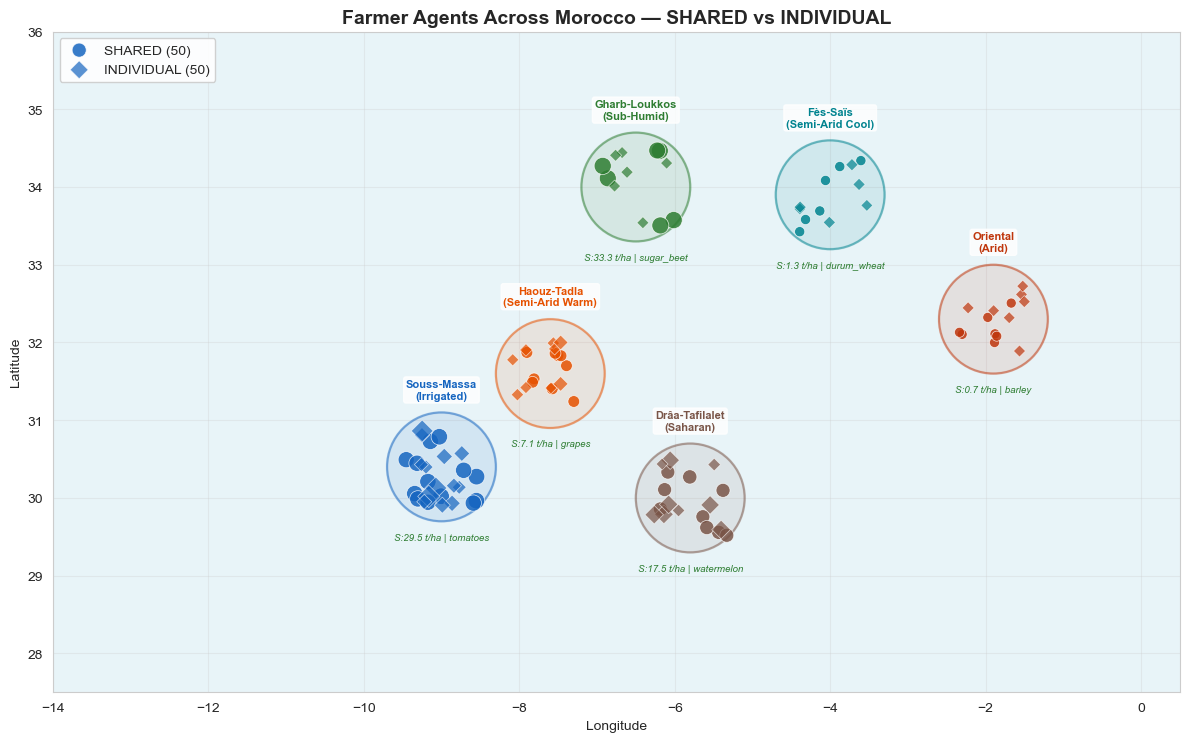

C:\Users\Salwa Khattami\AppData\Local\Temp\ipykernel_3948\2022898712.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="strategy", y="mean_yield", data=df, ax=axes[0], palette="Set2")
C:\Users\Salwa Khattami\AppData\Local\Temp\ipykernel_3948\2022898712.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="strategy", y="mean_profit", data=df, ax=axes[1], palette="Set2")


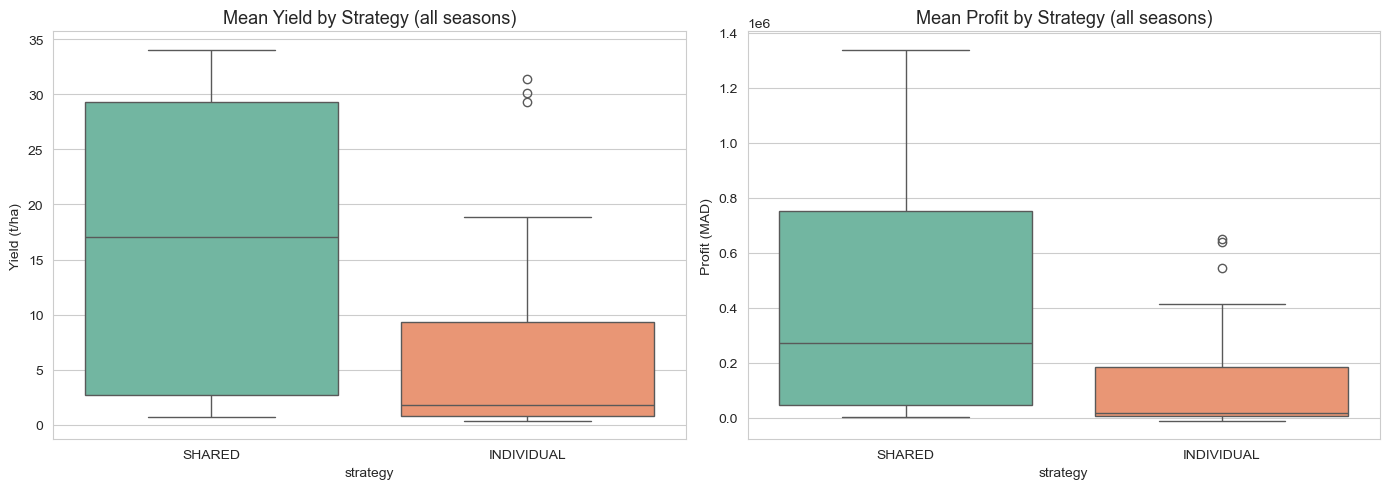

C:\Users\Salwa Khattami\AppData\Local\Temp\ipykernel_3948\2022898712.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="strategy", y="mean_yield", data=df, ax=axes[0],
C:\Users\Salwa Khattami\AppData\Local\Temp\ipykernel_3948\2022898712.py:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="strategy", y="mean_profit", data=df, ax=axes[1],


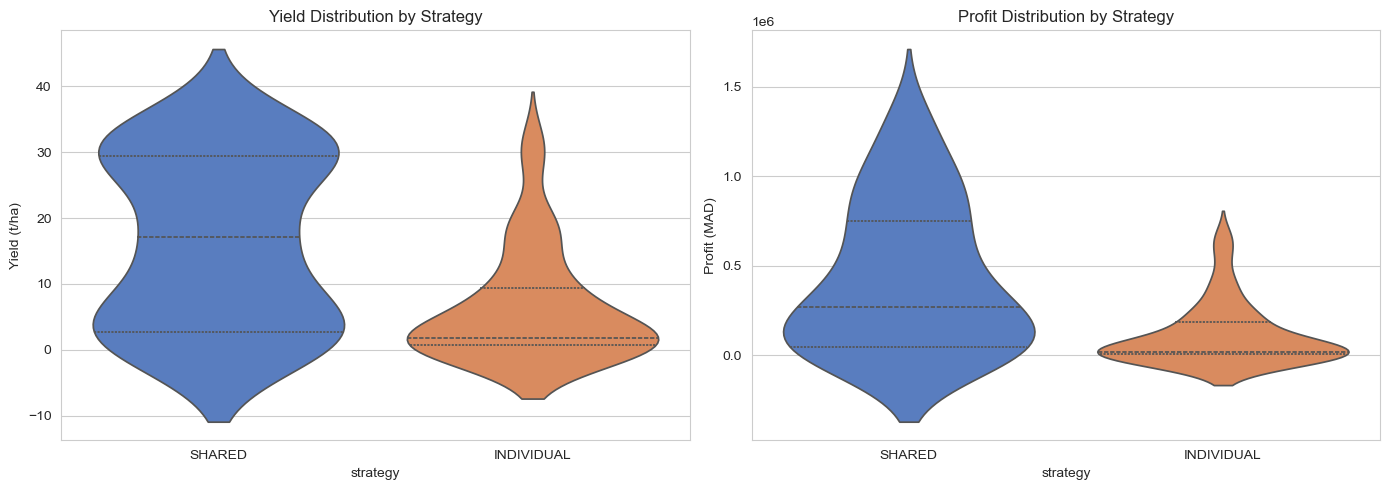

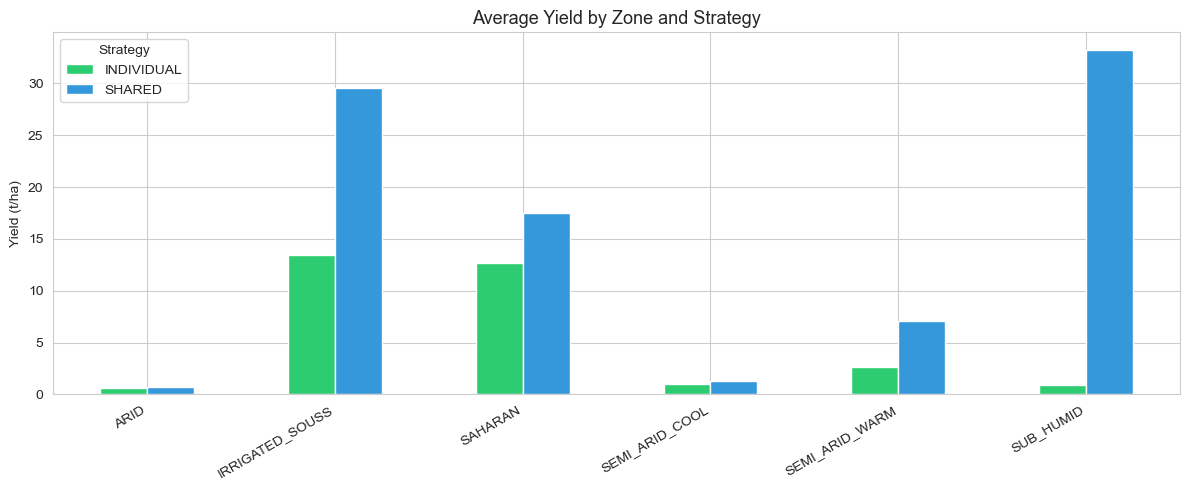

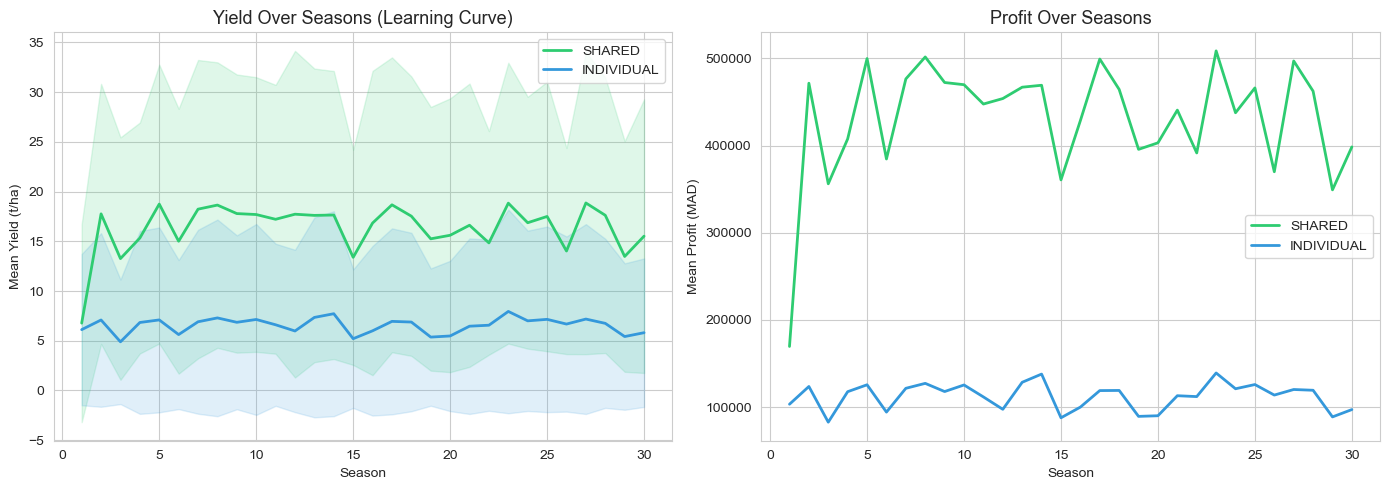

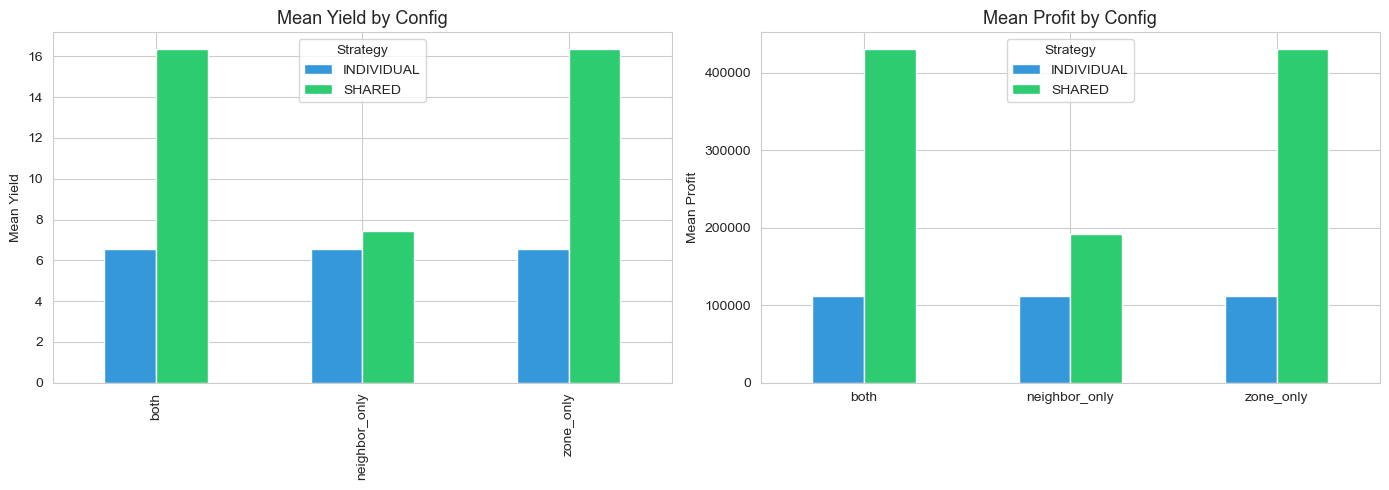

Results saved to results/
  - agents_results.csv (100 rows)
  - season_history.csv (30 rows)
  - strategy_comparison.csv
  - metrics.json
  - 5 PNG plots


In [ ]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({"figure.dpi": 100, "figure.figsize": (12, 5)})

try:
    import seaborn as sns
    sns.set_style("whitegrid")
    HAS_SNS = True
except ImportError:
    HAS_SNS = False

results_dir = Path("results")
results_dir.mkdir(exist_ok=True)

ZONE_COORDS = {
    "IRRIGATED_SOUSS": (30.4, -9.0, "Souss-Massa\n(Irrigated)"),
    "SUB_HUMID": (34.0, -6.5, "Gharb-Loukkos\n(Sub-Humid)"),
    "SEMI_ARID_WARM": (31.6, -7.6, "Haouz-Tadla\n(Semi-Arid Warm)"),
    "SEMI_ARID_COOL": (33.9, -4.0, "Fès-Saïs\n(Semi-Arid Cool)"),
    "ARID": (32.3, -1.9, "Oriental\n(Arid)"),
    "SAHARAN": (30.0, -5.8, "Drâa-Tafilalet\n(Saharan)"),
}
ZONE_COLORS = {
    "IRRIGATED_SOUSS": "#1565c0", "SUB_HUMID": "#2e7d32",
    "SEMI_ARID_WARM": "#e65100", "SEMI_ARID_COOL": "#00838f",
    "ARID": "#bf360c", "SAHARAN": "#795548",
}

fig, ax = plt.subplots(1, 1, figsize=(12, 9))
ax.set_facecolor("#e8f4f8")

for zid, (lat, lon, label) in ZONE_COORDS.items():
    circle = plt.Circle((lon, lat), 0.7, color=ZONE_COLORS[zid],
                         alpha=0.10, linewidth=2)
    ax.add_patch(circle)
    circle_border = plt.Circle((lon, lat), 0.7, fill=False,
                                color=ZONE_COLORS[zid], linewidth=1.5, alpha=0.5)
    ax.add_patch(circle_border)

rng_map = np.random.RandomState(42)
for strat, marker, size_base, alpha in [
    ("SHARED", "o", 50, 0.85),
    ("INDIVIDUAL", "D", 35, 0.70),
]:
    sub = df[df["strategy"] == strat]
    lats, lons, colors, sizes = [], [], [], []
    for _, row in sub.iterrows():
        coords = ZONE_COORDS.get(row["zone"])
        if not coords:
            continue
        lat, lon, _ = coords
        lats.append(lat + rng_map.uniform(-0.5, 0.5))
        lons.append(lon + rng_map.uniform(-0.5, 0.5))
        colors.append(ZONE_COLORS.get(row["zone"], "#666"))
        sizes.append(size_base + row["mean_yield"] * 3)
    ax.scatter(lons, lats, s=sizes, c=colors, marker=marker,
               alpha=alpha, edgecolors="white", linewidths=0.5,
               label=f"{strat} ({len(sub)})", zorder=3)

for zid, (lat, lon, label) in ZONE_COORDS.items():
    ax.annotate(label, (lon, lat + 0.85), fontsize=8, fontweight="bold",
                ha="center", va="bottom", color=ZONE_COLORS[zid],
                bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))

for zid, (lat, lon, _) in ZONE_COORDS.items():
    z_shared = df[(df["zone"] == zid) & (df["strategy"] == "SHARED")]
    z_indiv = df[(df["zone"] == zid) & (df["strategy"] == "INDIVIDUAL")]
    if len(z_shared) > 0:
        top_crop = z_shared["last_crop"].mode().iloc[0] if len(z_shared) > 0 else "?"
        ax.annotate(f"S:{z_shared['mean_yield'].mean():.1f} t/ha | {top_crop}",
                    (lon, lat - 0.85), fontsize=7, ha="center", va="top",
                    color="#2e7d32", fontstyle="italic")

ax.set_xlim(-14, 0.5)
ax.set_ylim(27.5, 36)
ax.set_xlabel("Longitude", fontsize=10)
ax.set_ylabel("Latitude", fontsize=10)
ax.set_title("Farmer Agents Across Morocco — SHARED vs INDIVIDUAL", fontsize=14, fontweight="bold")
ax.legend(loc="upper left", fontsize=10, framealpha=0.9)
ax.set_aspect("equal")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(results_dir / "00_morocco_map.png", bbox_inches="tight", dpi=150)
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

if HAS_SNS:
    sns.boxplot(x="strategy", y="mean_yield", data=df, ax=axes[0], palette="Set2")
else:
    for i, strat in enumerate(["SHARED", "INDIVIDUAL"]):
        sub = df[df["strategy"] == strat]["mean_yield"]
        axes[0].boxplot(sub, positions=[i], widths=0.5)
axes[0].set_title("Mean Yield by Strategy (all seasons)", fontsize=13)
axes[0].set_ylabel("Yield (t/ha)")

if HAS_SNS:
    sns.boxplot(x="strategy", y="mean_profit", data=df, ax=axes[1], palette="Set2")
else:
    for i, strat in enumerate(["SHARED", "INDIVIDUAL"]):
        sub = df[df["strategy"] == strat]["mean_profit"]
        axes[1].boxplot(sub, positions=[i], widths=0.5)
axes[1].set_title("Mean Profit by Strategy (all seasons)", fontsize=13)
axes[1].set_ylabel("Profit (MAD)")

plt.tight_layout()
plt.savefig(results_dir / "01_strategy_comparison.png", bbox_inches="tight")
plt.show()

if HAS_SNS:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.violinplot(x="strategy", y="mean_yield", data=df, ax=axes[0],
                   inner="quartile", palette="muted")
    axes[0].set_title("Yield Distribution by Strategy")
    axes[0].set_ylabel("Yield (t/ha)")

    sns.violinplot(x="strategy", y="mean_profit", data=df, ax=axes[1],
                   inner="quartile", palette="muted")
    axes[1].set_title("Profit Distribution by Strategy")
    axes[1].set_ylabel("Profit (MAD)")
    plt.tight_layout()
    plt.savefig(results_dir / "02_distribution_analysis.png", bbox_inches="tight")
    plt.show()

fig, ax = plt.subplots(figsize=(12, 5))
zone_perf = df.groupby(["zone", "strategy"])["mean_yield"].mean().unstack()
zone_perf.plot(kind="bar", ax=ax, color=["#2ecc71", "#3498db"])
ax.set_title("Average Yield by Zone and Strategy", fontsize=13)
ax.set_ylabel("Yield (t/ha)")
ax.set_xlabel("")
ax.legend(title="Strategy")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.savefig(results_dir / "03_zone_performance.png", bbox_inches="tight")
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(hist_df["season"], hist_df["shared_mean_yield"],
             label="SHARED", color="#2ecc71", linewidth=2)
axes[0].plot(hist_df["season"], hist_df["indiv_mean_yield"],
             label="INDIVIDUAL", color="#3498db", linewidth=2)
axes[0].fill_between(hist_df["season"],
                     hist_df["shared_mean_yield"] - hist_df["shared_std_yield"],
                     hist_df["shared_mean_yield"] + hist_df["shared_std_yield"],
                     alpha=0.15, color="#2ecc71")
axes[0].fill_between(hist_df["season"],
                     hist_df["indiv_mean_yield"] - hist_df["indiv_std_yield"],
                     hist_df["indiv_mean_yield"] + hist_df["indiv_std_yield"],
                     alpha=0.15, color="#3498db")
axes[0].set_title("Yield Over Seasons (Learning Curve)", fontsize=13)
axes[0].set_xlabel("Season")
axes[0].set_ylabel("Mean Yield (t/ha)")
axes[0].legend()

axes[1].plot(hist_df["season"], hist_df["shared_mean_profit"],
             label="SHARED", color="#2ecc71", linewidth=2)
axes[1].plot(hist_df["season"], hist_df["indiv_mean_profit"],
             label="INDIVIDUAL", color="#3498db", linewidth=2)
axes[1].set_title("Profit Over Seasons", fontsize=13)
axes[1].set_xlabel("Season")
axes[1].set_ylabel("Mean Profit (MAD)")
axes[1].legend()

plt.tight_layout()
plt.savefig(results_dir / "04_learning_curves.png", bbox_inches="tight")
plt.show()

if comp_df is not None and len(comp_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    for i, metric in enumerate(["mean_yield", "mean_profit"]):
        pivot = comp_df.pivot(index="config", columns="strategy", values=metric)
        pivot.plot(kind="bar", ax=axes[i], color=["#3498db", "#2ecc71"])
        axes[i].set_title(f"{metric.replace('_', ' ').title()} by Config", fontsize=13)
        axes[i].set_ylabel(metric.replace("_", " ").title())
        axes[i].set_xlabel("")
        axes[i].legend(title="Strategy")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(results_dir / "05_config_comparison.png", bbox_inches="tight")
    plt.show()

df.to_csv(results_dir / "agents_results.csv", index=False)
hist_df.to_csv(results_dir / "season_history.csv", index=False)
comp_df.to_csv(results_dir / "strategy_comparison.csv", index=False)

_shared_df = df[df["strategy"]=="SHARED"]
_indiv_df = df[df["strategy"]=="INDIVIDUAL"]
_avg_y_s = float(_shared_df["mean_yield"].mean())
_avg_y_i = float(_indiv_df["mean_yield"].mean())
_avg_p_s = float(_shared_df["mean_profit"].mean())
_avg_p_i = float(_indiv_df["mean_profit"].mean())

metrics = {
    "total_agents": int(len(df)),
    "shared_agents": int(len(_shared_df)),
    "individual_agents": int(len(_indiv_df)),
    "n_seasons": int(cfg.n_seasons),
    "shared_strategy": cfg.shared_strategy,
    "use_neighbor_graph": cfg.use_neighbor_graph,
    "avg_yield_shared": _avg_y_s,
    "avg_yield_individual": _avg_y_i,
    "yield_advantage_shared": round(_avg_y_s - _avg_y_i, 4),
    "avg_profit_shared": _avg_p_s,
    "avg_profit_individual": _avg_p_i,
    "profit_advantage_shared": round(_avg_p_s - _avg_p_i, 2),
    "profit_advantage_pct": round(pct, 2),
}
import json as _json
with open(results_dir / "metrics.json", "w") as f:
    _json.dump(metrics, f, indent=2)

print(f"Results saved to {results_dir}/")
print(f"  - agents_results.csv ({len(df)} rows)")
print(f"  - season_history.csv ({len(hist_df)} rows)")
print(f"  - strategy_comparison.csv")
print(f"  - metrics.json")